In [12]:
# Libraries

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms, models
from sklearn.metrics import confusion_matrix, classification_report
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import copy

In [13]:
# Data Preparation

# Load mean and std values from JSON
with open('mean_std.json', 'r') as f:
    mean_std = json.load(f)

mean = mean_std['mean']
std = mean_std['std']

# Data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [14]:
# Model Definition

# Define the MobileNetV2 model with frozen pretrained weights
def get_mobilenetv2_model(num_classes):
    model = models.mobilenet_v2(weights=None)
    
    # Freeze all the weights
    #for param in model.parameters():
    #    param.requires_grad = False

    # Replace the last layer with a new one (unfrozen) for our specific number of classes
    num_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_features, num_classes)
    
    return model

In [15]:
# Training and Validation Functions with Early Stopping 

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=3):
    best_model_wts = model.state_dict()
    best_loss = float('inf')
    patience_counter = 0

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = corrects.double() / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc.item())

        val_loss, val_acc, val_labels, val_preds = evaluate_model(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc.item())

        print(f'Epoch {epoch + 1}/{num_epochs} - '
              f'Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc * 100:.4f}% - '
              f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc * 100:.4f}%')

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping")
            break

    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses, train_accuracies, val_accuracies

def evaluate_model(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    corrects = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.data)
            running_loss += loss.item() * inputs.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    loss = running_loss / len(dataloader.dataset)
    accuracy = corrects.double() / len(dataloader.dataset)
    return loss, accuracy, all_labels, all_preds

Starting training for fold 0...
Epoch 1/10 - Train Loss: 1.1704, Train Accuracy: 47.9167% - Val Loss: 2.2849, Val Accuracy: 30.2083%
Epoch 2/10 - Train Loss: 0.9310, Train Accuracy: 63.8021% - Val Loss: 3.5267, Val Accuracy: 30.2083%
Epoch 3/10 - Train Loss: 0.7813, Train Accuracy: 67.9688% - Val Loss: 4.3550, Val Accuracy: 30.2083%
Epoch 4/10 - Train Loss: 0.5064, Train Accuracy: 83.0729% - Val Loss: 5.6051, Val Accuracy: 30.2083%
Early stopping
Model for fold 0 saved at mobilenetv2_fold_0.pth
Evaluating model for fold 0...
Val Loss: 5.6051, Val Accuracy: 30.2083%


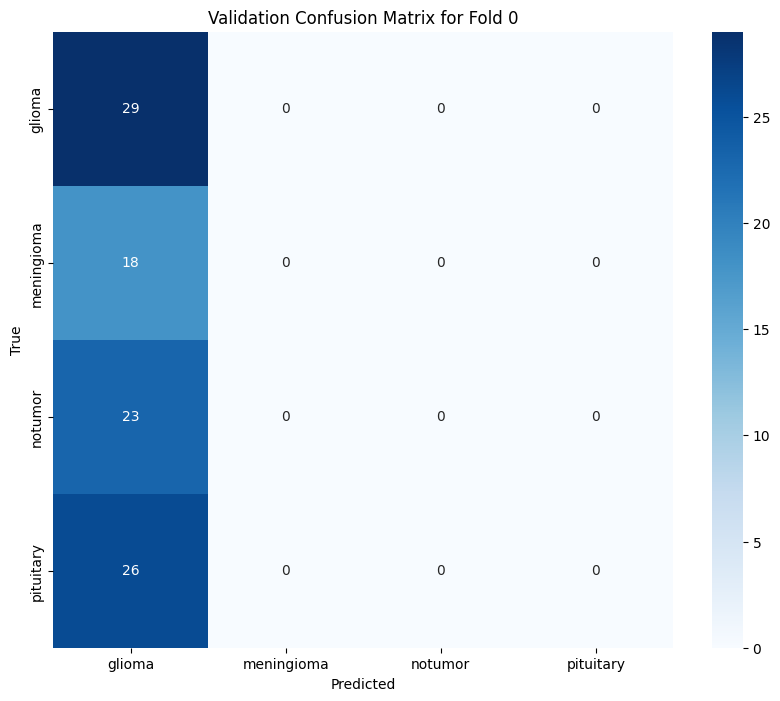

Training and evaluation for fold 0 completed.

Starting training for fold 1...
Epoch 1/10 - Train Loss: 1.1416, Train Accuracy: 47.3958% - Val Loss: 1.9239, Val Accuracy: 31.2500%
Epoch 2/10 - Train Loss: 0.8905, Train Accuracy: 63.0208% - Val Loss: 2.2631, Val Accuracy: 31.2500%
Epoch 3/10 - Train Loss: 0.7230, Train Accuracy: 72.1354% - Val Loss: 1.9519, Val Accuracy: 31.2500%
Epoch 4/10 - Train Loss: 0.5587, Train Accuracy: 76.8229% - Val Loss: 2.6693, Val Accuracy: 31.2500%
Early stopping
Model for fold 1 saved at mobilenetv2_fold_1.pth
Evaluating model for fold 1...
Val Loss: 2.6693, Val Accuracy: 31.2500%


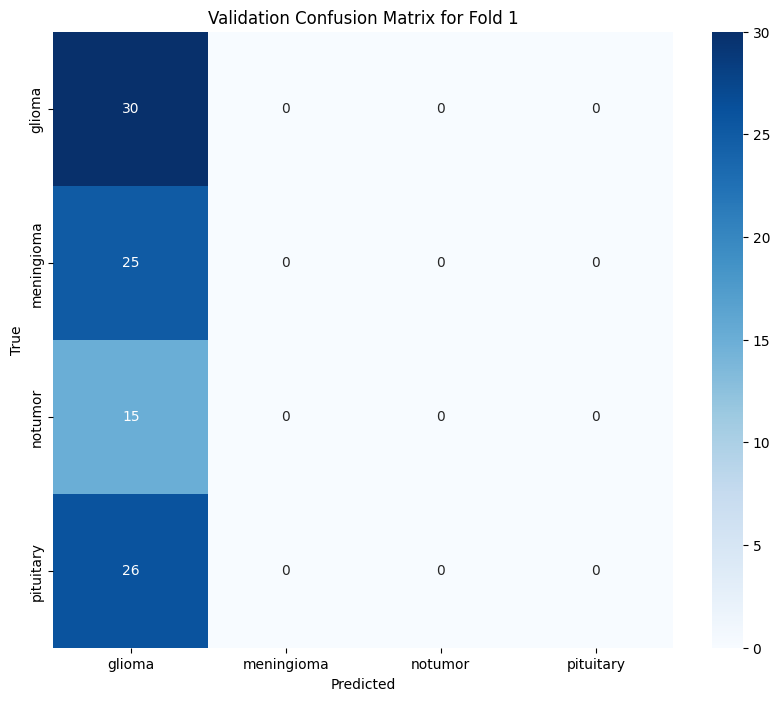

Training and evaluation for fold 1 completed.

Starting training for fold 2...
Epoch 1/10 - Train Loss: 1.2705, Train Accuracy: 42.1875% - Val Loss: 1.9837, Val Accuracy: 16.6667%
Epoch 2/10 - Train Loss: 0.8933, Train Accuracy: 64.5833% - Val Loss: 2.4476, Val Accuracy: 16.6667%
Epoch 3/10 - Train Loss: 0.6363, Train Accuracy: 74.4792% - Val Loss: 2.8737, Val Accuracy: 16.6667%
Epoch 4/10 - Train Loss: 0.5113, Train Accuracy: 82.8125% - Val Loss: 3.3992, Val Accuracy: 16.6667%
Early stopping
Model for fold 2 saved at mobilenetv2_fold_2.pth
Evaluating model for fold 2...
Val Loss: 3.3992, Val Accuracy: 16.6667%


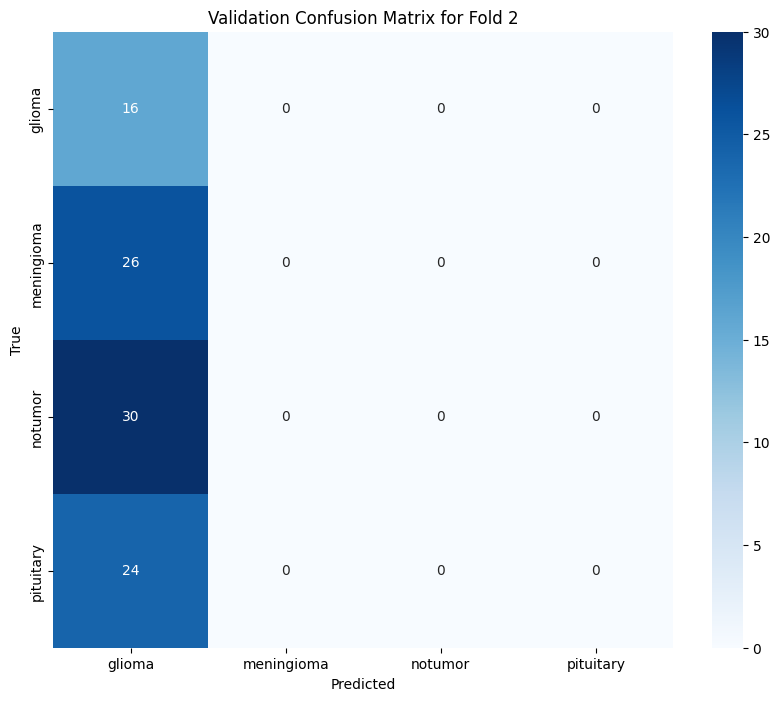

Training and evaluation for fold 2 completed.

Starting training for fold 3...
Epoch 1/10 - Train Loss: 1.2228, Train Accuracy: 43.4896% - Val Loss: 2.3103, Val Accuracy: 23.9583%
Epoch 2/10 - Train Loss: 0.8363, Train Accuracy: 67.1875% - Val Loss: 2.4801, Val Accuracy: 23.9583%
Epoch 3/10 - Train Loss: 0.7719, Train Accuracy: 69.7917% - Val Loss: 2.6259, Val Accuracy: 23.9583%
Epoch 4/10 - Train Loss: 0.5736, Train Accuracy: 76.0417% - Val Loss: 3.3810, Val Accuracy: 23.9583%
Early stopping
Model for fold 3 saved at mobilenetv2_fold_3.pth
Evaluating model for fold 3...
Val Loss: 3.3810, Val Accuracy: 23.9583%


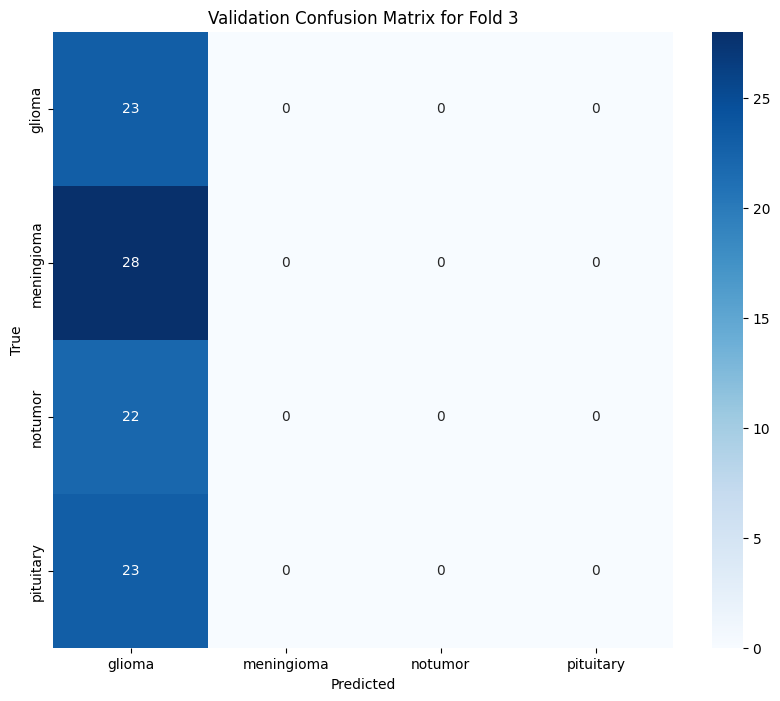

Training and evaluation for fold 3 completed.

Starting training for fold 4...
Epoch 1/10 - Train Loss: 1.1058, Train Accuracy: 47.9167% - Val Loss: 2.0868, Val Accuracy: 22.9167%
Epoch 2/10 - Train Loss: 0.8436, Train Accuracy: 65.6250% - Val Loss: 2.4808, Val Accuracy: 22.9167%
Epoch 3/10 - Train Loss: 0.6448, Train Accuracy: 74.2188% - Val Loss: 2.4838, Val Accuracy: 22.9167%
Epoch 4/10 - Train Loss: 0.6117, Train Accuracy: 74.7396% - Val Loss: 2.4440, Val Accuracy: 22.9167%
Early stopping
Model for fold 4 saved at mobilenetv2_fold_4.pth
Evaluating model for fold 4...
Val Loss: 2.4440, Val Accuracy: 22.9167%


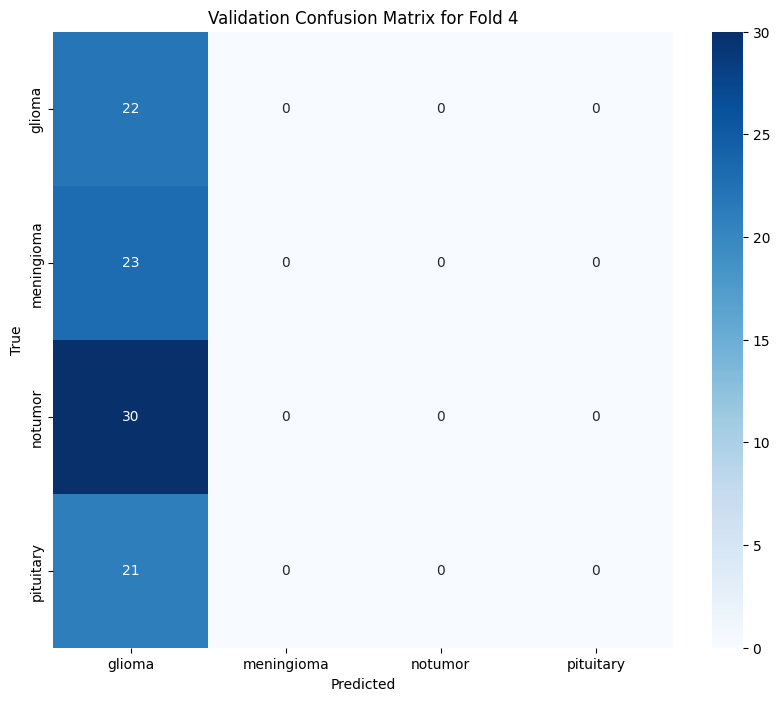

Training and evaluation for fold 4 completed.

Summary of cross-validation results:
Mean validation accuracy: 25.0000%
Standard deviation of validation accuracy: 5.3115%


In [16]:
# Main Script

# Base directory containing the k-fold datasets
base_dir = 'dataset_kfold'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

all_train_losses = []
all_val_losses = []
all_train_accuracies = []
all_val_accuracies = []
fold_accuracies = []

# Loop through each fold directory
for fold in range(5):
    print(f'Starting training for fold {fold}...')
    
    fold_dir = os.path.join(base_dir, f'fold_{fold}')
    train_dir = os.path.join(fold_dir, 'train')
    val_dir = os.path.join(fold_dir, 'val')

    # Load the datasets
    train_dataset = ImageFolder(root=train_dir, transform=transform)
    val_dataset = ImageFolder(root=val_dir, transform=transform)

    # Data loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

    # Get the model and move it to the appropriate device
    num_classes = len(train_dataset.classes)
    model = get_mobilenetv2_model(num_classes).to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train and evaluate the model
    model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(
        model, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=3)
    
    # Save the model for this fold
    model_path = f'mobilenetv2_fold_{fold}.pth'
    torch.save(model.state_dict(), model_path)
    print(f'Model for fold {fold} saved at {model_path}')

    # Collecting results for plotting
    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)
    all_train_accuracies.append(train_accuracies)
    all_val_accuracies.append(val_accuracies)
    
    print(f'Evaluating model for fold {fold}...')
    val_loss, val_acc, val_labels, val_preds = evaluate_model(model, val_loader, criterion)
    fold_accuracies.append(val_acc.item())
    print(f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc * 100:.4f}%')

    # Confusion Matrix
    cm = confusion_matrix(val_labels, val_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Validation Confusion Matrix for Fold {fold}')
    plt.show()

    print(f'Training and evaluation for fold {fold} completed.\n')

# Summary of results across all folds
print('Summary of cross-validation results:')
print(f'Mean validation accuracy: {np.mean(fold_accuracies) * 100:.4f}%')
print(f'Standard deviation of validation accuracy: {np.std(fold_accuracies) * 100:.4f}%')